# Analysis of NIST Ground dataset

This notebook uses PVPRO to analyze the NIST dataset.

The NIST dataset is publicly available here: https://pvdata.nist.gov/




In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import json

from sys import path
from solardatatools import DataHandler

from glob import glob
from pickle import load, dump
from pvlib.pvsystem import retrieve_sam

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import sys


In [103]:

from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor

from pvpro.plotting import plot_Vmp_Imp_scatter, plot_poa_Imp_scatter, plot_results_timeseries
from pvanalytics.features import clipping

from pvpro.postprocess import analyze_yoy
from pvpro.plotting import plot_results_timeseries
from pvpro.plotting import plot_results_timeseries_error

import seaborn as sns

from datetime import datetime


## Load data

Load dataframe and info files.

In [3]:
# Require the download of NIST-ground dataset from:
# https://datahub.duramat.org/dataset/752151f8-7ba3-486e-954c-0126227f89b5/resource/e40a91f9-fa84-4a2b-b6d8-312c15fc761b/download/nist01_onemin-ground.pkl
sys_name = 'NIST-ground'
dfi = pd.read_pickle('data/nist01_onemin-Ground.pkl')
df = dfi[::20]

Input Metadata

In [4]:
modules_per_string = 12
parallel_strings = 96
voltage_dc_key = 'InvVDCin_Avg'
current_dc_key = 'InvIDCin_Avg'
temperature_module_key= 'RTD_C_Avg_4'
irradiance_poa_key = 'RefCell1_Wm2_Avg'
cells_in_series = 60
alpha_isc = 0.053e-2*8.6
delta_T = 3
technology = 'mono-Si' # specify PV technology
band_gap = 1.121
dEgdT = -0.0002677

Get module from CEC database. Or can enter parameters manually. Only need a dictionary with 'alpha_sc' (units of A/C), 'R_sh_ref' and 'N_s'.

In [5]:
cec = retrieve_sam('CECmod')
module = cec['Sharp_NU_U235F2']
print(module)
module['alpha_sc'] = alpha_isc

Technology            Mono-c-Si
Bifacial                      0
STC                       235.2
PTC                       211.9
A_c                       1.573
Length                    1.618
Width                     0.972
N_s                          60
I_sc_ref                    8.6
V_oc_ref                   37.0
I_mp_ref                   7.84
V_mp_ref                   30.0
alpha_sc               0.003784
beta_oc                -0.12173
T_NOCT                     45.4
a_ref                  1.572369
I_L_ref                8.628778
I_o_ref                     0.0
R_s                    0.300444
R_sh_ref              89.785065
Adjust                14.428038
gamma_r                  -0.458
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Sharp_NU_U235F2, dtype: object


## Initiate PVPRO

Instantiate PVPRO data handler.

In [6]:
pre = Preprocessor(df,
                   voltage_dc_key=voltage_dc_key,
                   current_dc_key=current_dc_key,
                   temperature_module_key=temperature_module_key,
                   irradiance_poa_key=irradiance_poa_key,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   )

In [7]:
pre.calculate_cell_temperature(delta_T=3)

Cell temperature assigned to 'temperature_cell'


In [8]:
method='sdt'
if method=='sdt':
    pre.run_preprocess_sdt(correct_dst=True)
    pre.classify_points_sdt()
    pre.build_operating_cls()

elif method=='fast':
    pre.classify_points_pva()
    pre.build_operating_cls()


Fixing daylight savings time shift...
Running solar data tools...
CAUTION: Time zone offset error detected, but TZ correction flag turned off!
Recommend checking timezone localization in data or turning on TZ correction flag.


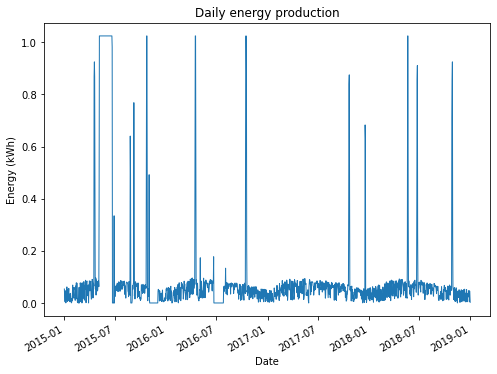

In [9]:
fig = pre.dh.plot_daily_energy()

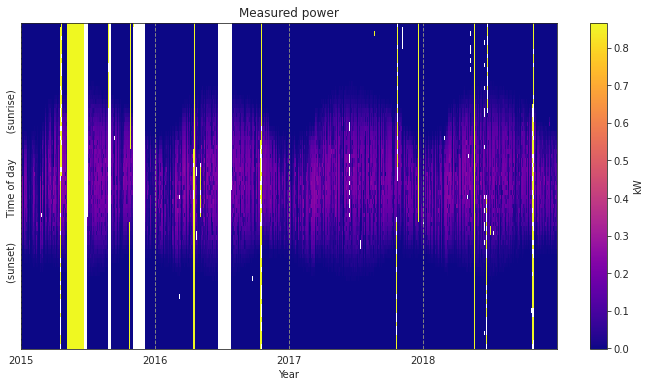

In [10]:
if method=='sdt':
    fig = pre.dh.plot_heatmap()

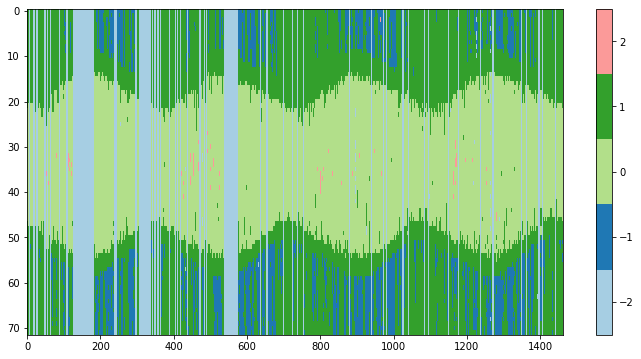

In [11]:
if method=='sdt':
    fig = pre.plot_operating_cls()

In [12]:
filter_IE = pre.find_current_irradiance_outliers(points_per_iteration=5000)

In [13]:
max_k = len(filter_IE['upper_iter_idx'])
poa = pre.df[pre.irradiance_poa_key]
current = pre.df[pre.current_dc_key]/pre.parallel_strings
@interact
def show_inbounds_IE(k=(0,max_k,1)):

    k = round(k)
    cax = np.arange(filter_IE['lower_iter_idx'][k], filter_IE['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and(np.logical_not(filter_IE['outliers'][cax]), filter_IE['boolean_mask'][cax])
    outliers =  np.logical_and(filter_IE['outliers'][cax],filter_IE['boolean_mask'][cax])
    
    x_smooth = np.linspace(0,1200,5)
    fig = plt.figure()
    plt.scatter(poa[cax][inbounds],current[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_IE['huber'][k].coef_ * x_smooth + filter_IE['huber'][k].intercept_,'g')

    plt.scatter(poa[cax][outliers], current[cax][outliers], s=1,
               c='r',label='Outliers')
    plt.xlabel('POA (W/m^2)')
    plt.ylabel('Current (A)')
    plt.xlim([0,1200])
    plt.ylim([0,11])
    plt.legend()
    plt.show()



interactive(children=(IntSlider(value=9, description='k', max=19), Output()), _dom_classes=('widget-interact',…

In [14]:
filter_TV= pre.find_temperature_voltage_outliers(voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=50000,
                                                 epsilon=3)

In [15]:
max_k = len(filter_TV['upper_iter_idx'])
poa = pre.df[pre.irradiance_poa_key]
current = pre.df[pre.current_dc_key]/pre.parallel_strings
voltage = pre.df[pre.voltage_dc_key]/pre.modules_per_string
temperature_cell = pre.df['temperature_cell']
@interact
def show_inbounds_TV(k=(0,max_k,1)):
    k = round(k)
    cax = np.arange(filter_TV['lower_iter_idx'][k], filter_TV['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and.reduce((
        np.logical_not(filter_TV['outliers'][cax]),
        filter_TV['boolean_mask'][cax]
    ))
    outliers =  np.logical_and(filter_TV['outliers'][cax],        filter_TV['boolean_mask'][cax])

    x_smooth = np.linspace(0,70,2)
    fig = plt.figure()
    plt.scatter(temperature_cell[cax][inbounds],voltage[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_TV['huber'][k].coef_ * x_smooth + filter_TV['huber'][k].intercept_,'g')
    # print(filter_TV['huber'][k].coef_)

    plt.scatter(temperature_cell[cax][outliers], voltage[cax][outliers], s=1,
                c='r',label='Outliers')
    plt.xlabel('Cell Temperature (C)')
    plt.ylabel('Voltage (V)')
    plt.xlim([-20,70])
    plt.ylim([0,70])
    plt.legend()
    plt.show()


interactive(children=(IntSlider(value=0, description='k', max=1), Output()), _dom_classes=('widget-interact',)…

In [16]:
filter_clear_time=True
if filter_clear_time:
    pre.find_clear_times_sdt()

No SCSF model detected. Fitting now...
----------------------
SCSF Problem Setup
----------------------
Matrix Size: 72 x 1461 = 105192 power measurements
Sparsity: 86.20%
14512 non-zero measurements under clear conditions
Model size: 72 x 6 + 6 x 1461 = 9198 parameters


----------------------
Algorithm Iterations
----------------------
Starting at Objective: 7.609e+07, f1: 1.324e+05, f2: 8.067e+02, f3: 5.383e+07, f4: 2.212e+07
    Minimizing left matrix


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


    Minimizing right matrix
1 - Objective: 5.395e+04, f1: 5.048e+04, f2: 6.156e+02, f3: 2.862e+03, f4: 1.310e-06
    Minimizing left matrix
    Minimizing right matrix
2 - Objective: 5.200e+04, f1: 4.862e+04, f2: 5.059e+02, f3: 2.867e+03, f4: 2.228e-07
    Minimizing left matrix
    Minimizing right matrix
3 - Objective: 5.185e+04, f1: 4.846e+04, f2: 5.342e+02, f3: 2.863e+03, f4: 3.715e-06
    Minimizing left matrix
    Minimizing right matrix
4 - Objective: 5.180e+04, f1: 4.840e+04, f2: 5.396e+02, f3: 2.860e+03, f4: 3.545e-06
Minimization complete in 1.62 minutes


In [17]:
power = pre.df['power_dc']
@interact
def inspect_clear_time(plot_start=(0,len(power),100)):
    plt.figure(figsize=(11,3))
    N = 300
    cax = np.arange(plot_start,plot_start+N).astype('int')
#     mask = pre.df['monotonic'][cax]
    plt.plot(pre.df.index[cax], power[plot_start:plot_start+N])
#     plt.plot(pre.df.index[cax][mask], power[cax][mask],
#             'r.',label='Monotonic')
    if 'clear_time' in pre.df:
        mask = pre.df['clear_time'][cax]
        plt.plot(pre.df.index[cax][mask], power[cax][mask],
            'r.',label='Clear time SDT')
    plt.legend()
    plt.ylabel('Power per module (W)')
    plt.show()

interactive(children=(IntSlider(value=52900, description='plot_start', max=105802, step=100), Output()), _dom_…

In [18]:
pre.dh.filled_data_matrix[pre.dh.filled_data_matrix>700]=0

In [19]:
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting

iterative_fitting = IterativeFitting(pre.dh.filled_data_matrix)
run_scsf = False
if run_scsf:
    iterative_fitting.execute(bootstraps=5)

In [20]:
if run_scsf:
    clear_sky_signals = iterative_fitting.clear_sky_signals()
    degradation_rate = iterative_fitting.degradation_rate()
    print(degradation_rate)
    print(iterative_fitting.beta_value)
    beta = []
    for j in range(len(iterative_fitting.bootstrap_samples)):
        beta.append(iterative_fitting.bootstrap_samples[j]['beta'])
        
    print(beta)
    print('{:.1%} pm {:.1%}'.format(np.mean(beta), np.std(beta)))


In [21]:
pre.find_monotonic_times()

In [22]:
N = 5000
@interact
def inspect_kept_points(start_point=(0,len(pre.df),N),
                        current_irradiance_filter=True,
                        monotonic_filter=True,
                        clipping_filter=False,
                       clear_time_filter=False,
                        voltage_temperature_filter=True,
                        
                       ):

    cax = np.arange(start_point, start_point+N).astype('int')
#     cax = range(start_point, start_point+N)

    
    mask = np.array(pre.df['operating_cls'][cax]==0)
    
    voltage = pre.df[pre.voltage_dc_key][cax]/pre.modules_per_string
    current = pre.df[pre.current_dc_key][cax]/pre.parallel_strings
    poa = pre.df[pre.irradiance_poa_key][cax]
    temperature_cell = pre.df['temperature_cell'][cax]
    operating_cls = pre.df['operating_cls'][cax]/pre.parallel_strings
    
    if current_irradiance_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['current_irradiance_outliers'][cax]) )
    if clipping_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['clipped_times'][cax]))
    if monotonic_filter:
        mask = np.logical_and(mask, pre.df['monotonic'][cax])
    if clear_time_filter and 'clear_time' in pre.df:
        mask = np.logical_and(mask, np.array(pre.df['clear_time'][cax]))
            
    if voltage_temperature_filter:
        mask = np.logical_and(mask, np.logical_not(pre.df['voltage_temperature_outliers'][cax]))
        
    
    
    fig = plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plot_Vmp_Imp_scatter(voltage=voltage,
                         current=current,
                         poa=poa,
                         temperature_cell=temperature_cell,
                         operating_cls=operating_cls,
                         boolean_mask=mask,
                            plot_vmp_max=45,
                            plot_imp_max=10)
    plt.subplot(1,2,2)
    plot_poa_Imp_scatter(current=current,
                         poa=poa,
                         temperature_cell=temperature_cell,
                         operating_cls=operating_cls,
                         boolean_mask=mask,
                            plot_imp_max=10)
    plt.show()

interactive(children=(IntSlider(value=50000, description='start_point', max=105802, step=5000), Checkbox(value…

## Perform PVPRO analysis

In [23]:
pvp = PvProHandler(df=pre.df,
                  voltage_key=voltage_dc_key,
                   current_key=current_dc_key,
                   irradiance_poa_key=irradiance_poa_key,
                   temperature_cell_key='temperature_cell',
                   alpha_isc=alpha_isc,
                   cells_in_series=cells_in_series,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   resistance_shunt_ref=module['R_sh_ref'],
                   system_name=sys_name
                  )

In [24]:
boolean_mask = np.logical_or.reduce((np.logical_and.reduce((
                                        np.logical_not(pre.df['current_irradiance_outliers']),
                                        np.logical_not(pre.df['clipped_times']),
                                        np.logical_not(pre.df['voltage_temperature_outliers']),
                                        pvp.df[pvp.irradiance_poa_key]>200
                                        )),
                                     pvp.df['operating_cls']==1,
                                     pvp.df['operating_cls']==2
                                    ))


In [25]:
pvp.estimate_p0(boolean_mask=np.logical_and.reduce((
                                        np.logical_not(pre.df['current_irradiance_outliers']),
                                        np.logical_not(pre.df['clipped_times']),
                                        np.logical_not(pre.df['voltage_temperature_outliers']),
                                        pvp.df[pvp.irradiance_poa_key]>500,
                                        )),
                                    technology = technology

                                    )
print(pd.Series(pvp.p0))

diode_factor               9.924871e-01
photocurrent_ref           8.788338e+00
saturation_current_ref     4.405906e-10
resistance_series_ref      3.278459e-01
resistance_shunt_ref       6.000000e+02
conductance_shunt_extra    0.000000e+00
v_oc_ref                   3.629124e+01
i_mp_ref                   8.195744e+00
i_sc_ref                   8.746322e+00
v_mp_ref                   2.948430e+01
p_mp_ref                   2.416457e+02
alpha_isc                  4.392762e-03
alpha_imp                 -6.178560e-03
beta_vmp                  -1.327267e-01
beta_voc                  -1.296508e-01
cells_in_series            6.000000e+01
nNsVth_ref                 1.530531e+00
dtype: float64


In [26]:
pvp.df['band_gap_ref'] = band_gap
pvp.df['dEgdT'] = dEgdT

Inspect the startpoint.

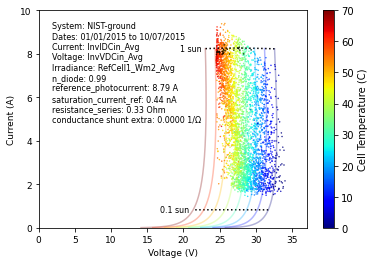

In [27]:
pvp.plot_Vmp_Imp_scatter(
        df=pvp.df[boolean_mask][:10000],
        p_plot=pvp.p0,
        figure_number=4,
        plot_imp_max=10,
        plot_vmp_max=37)

In [77]:
hyperparams = {
    'use_voc_points': False,
    'use_mpp_points': True,
    'use_clip_points': False,
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    'diode_factor': 1.1, #pvp.p0['diode_factor'],
    'days_per_run': 365.25/24,
    'iterations_per_year': 24,
    'start_point_method': 'last',
    'saturation_current_multistart': [1],
    'plot_imp_max': 10,
    'plot_vmp_max': 45,
    'save_figs': False,
    'verbose': False,
}

Execute parameter extraction:

In [78]:
# add Rsh for fitting
pvp.resistance_shunt_ref = None

fit_params = ['photocurrent_ref', 'saturation_current_ref',
                          'resistance_series_ref', 
                         'conductance_shunt_extra',
                         'resistance_shunt_ref', 
                          'diode_factor']
lower_bounds = dict(
            diode_factor=1.1,
            photocurrent_ref=0.01,
            saturation_current_ref=5e-12,
            resistance_series_ref=0.1,
            conductance_shunt_extra=0,
            resistance_shunt_ref=10
        )

upper_bounds = dict(
    diode_factor=1.1,
    photocurrent_ref=10,
    saturation_current_ref=1e-6,
    resistance_series_ref=2,
    conductance_shunt_extra=0,
    resistance_shunt_ref=1000
)
ret = pvp.execute(iteration='all', fit_params= fit_params,
                lower_bounds=lower_bounds,
                upper_bounds=upper_bounds,
                  **hyperparams,
                  boolean_mask = boolean_mask,
                  technology=technology) 

100%|██████████| 95/95 [00:19<00:00,  4.82it/s]

Elapsed time: 0.33 min


Pull out results and inspect goodness of fit.

In [119]:
pfit = pvp.result['p']

In [121]:
@interact
def inspect_results(k=(0,len(pfit),1),filter=True):

    cax = np.logical_and(
        pvp.df.index>pfit['t_start'][k],
        pvp.df.index<pfit['t_end'][k]
    )
    if filter:
        mask = boolean_mask[cax]
    else:
        mask = np.ones_like(boolean_mask[cax])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    pvp.plot_Vmp_Imp_scatter(df=pvp.df[cax][mask],
                                p_plot=pfit.iloc[k],
                            plot_vmp_max=37,
                            plot_imp_max=10)
    plt.subplot(1,2,2)
    pvp.plot_current_irradiance_mpp_scatter(df=pvp.df[cax][mask],

                                            p_plot=pfit.iloc[k],
                            plot_imp_max=10)
    plt.gcf().set_dpi(400)
    plt.show()

interactive(children=(IntSlider(value=47, description='k', max=95), Checkbox(value=True, description='filter')…

## Plot timeseries results of estimated parameters

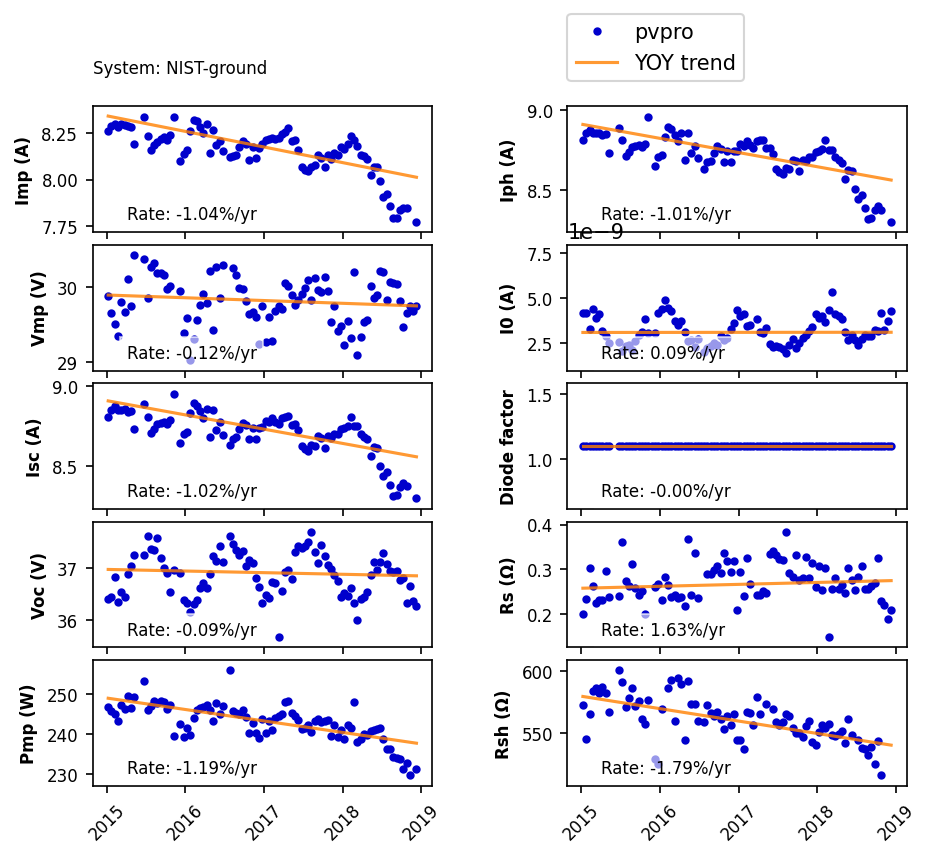

In [122]:


extra_text = 'System: {}\n'.format(pvp.system_name)

keys_to_plot = ['i_mp_ref', 'photocurrent_ref',
                        'v_mp_ref', 'saturation_current_ref',
                        'i_sc_ref', 'diode_factor',
                        'v_oc_ref', 'resistance_series_ref',
                        'p_mp_ref', 'resistance_shunt_ref'
                        ]
                        
for key in keys_to_plot:
    para = pfit[key]
    inx = (para <np.mean(para)-3*np.std(para)) | (para >np.mean(para)+3*np.std(para))
    pfit[key][inx] = np.nan

yoy_result = analyze_yoy(pfit)

plot_results_timeseries(pfit,yoy_result,extra_text=extra_text, 
                        keys_to_plot=keys_to_plot)
plt.gcf().set_dpi(150)